<a href="https://colab.research.google.com/github/evanphilipsmith/infant-cry-prediction/blob/main/infant_cry.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load the Data

## Load Donate-a-Cry Corpus

### Setup

In [ ]:
%%capture
# Clone Donate-a-cry corpus (if not already cloned)
![ ! -d donateacry-corpus ] && git clone https://github.com/gveres/donateacry-corpus.git

In [ ]:
!pip install torchaudio

     |████████████████████████████████| 7.6MB 5.8MB/s 


### Imports

In [ ]:
from IPython.display import Audio, display
from pathlib import Path
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchaudio
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import pdb
from tqdm import tqdm
import gc
from google.colab import files, drive
from IPython.core.ultratb import AutoFormattedTB
__ITB__ = AutoFormattedTB(mode = 'Verbose',color_scheme='LightBg')

torchaudio.set_audio_backend("sox_io")

drive.mount('/content/drive')

/usr/local/lib/python3.6/dist-packages/torchaudio/backend/utils.py:54: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  '"sox" backend is being deprecated. '


Mounted at /content/drive


### Dataset initialization

In [ ]:
class DonateACryDataset(Dataset):
    def __init__(self, wav_dirs: list, train=False, clip=None, drop_hungry=None, random_state=0):
        super(DonateACryDataset, self).__init__()
        columns = [
            'instance_id',
            'timestamp',
            'version',
            'gender',
            'age',
            'target',
            'waveform',
            'sample_rate'
        ]
        self.data = pd.DataFrame(columns=columns)
        
        for dir in wav_dirs:
            self.add_files_from_dir(dir)

        if drop_hungry:
            random_hungry_samples = self.data[self.data.target=='hu'].sample(frac=drop_hungry, random_state=random_state)
            self.data.drop(random_hungry_samples.index, inplace=True)
        
        self.normalize_features()
        
        self.target_encoding = { tag: i for i, tag in enumerate(self.data.target.unique()) }
        self.target_decoding = { i: tag for tag, i in self.target_encoding.items() }
        self.encode_target()

        self.split_data(train, random_state=random_state)

        if clip:
            self.data = self.data.iloc[:clip]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        x_labels = self.data.columns.drop('target')
        return self.data.iloc[index]['waveform'], self.data.iloc[index]['target']

    @staticmethod
    def parse_filename(filename):
        return (filename[:36], *filename[37:-4].split('-'))

    def normalize_features(self, merge_coldhot=True):
        # make age readable

        # make target readable
        readable_targets = {
            'hu': 'hungry',
            'bu': 'needs burping',
            'bp': 'belly pain',
            'dc': 'discomfort',
            'ti': 'tired',
        }
        if merge_coldhot:
            readable_targets['ch'] = 'discomfort'
        self.data.target.replace(readable_targets, inplace=True)
        
        # make timestamp readable
        
        # normalize waveform tensors to be the same length
        length = lambda x: x.shape[1]
        max_length = self.data.waveform.apply(length).max()
        padding = lambda x: (0, max_length-length(x))
        add_padding = lambda x: F.pad(x, padding(x), 'constant', 0)
        self.data.loc[:, 'waveform'] = self.data.waveform.apply(add_padding)

    def split_data(self, train, random_state):
        split = train_test_split(self.data, train_size=0.8, stratify=self.data.target, random_state=random_state)
        if train:
            self.data = split[0]
        else:
            self.data = split[1]

    def encode_target(self):
        self.data.target.replace(self.target_encoding, inplace=True)

    def decode_target(self):
        self.data.target.replace(self.target_decoding, inplace=True)
    
    def value_counts(self):
        return self.data.target.replace(self.target_decoding).value_counts()

    def add_files_from_dir(self, containing_dir: str):
        for dirpath, _, filenames in os.walk(containing_dir):
            for filename in filenames:
                try:
                    if filename.endswith('.wav'):
                        self.data.loc[len(self.data)] = [
                            *self.parse_filename(filename),
                            *torchaudio.load(os.path.join(dirpath, filename))
                        ]
                except ValueError:
                    print(f'skipping {filename}')

In [ ]:
clean_dirs = ['./donateacry-corpus/donateacry_corpus_cleaned_and_updated_data/']
clean_train_data = DonateACryDataset(clean_dirs, train=True, drop_hungry=0.75)
clean_test_data = DonateACryDataset(clean_dirs, train=False, drop_hungry=0.75)

assert clean_train_data.target_decoding == clean_test_data.target_decoding

In [ ]:
print(clean_train_data.value_counts())
print()
print(clean_test_data.value_counts())

hungry           305
discomfort        22
tired             19
belly pain        13
needs burping      6
Name: target, dtype: int64

hungry           77
tired             5
discomfort        5
belly pain        3
needs burping     2
Name: target, dtype: int64

[0 1]


## Current RNN implementation
* train all windows at once
* compatible with batches

In [ ]:
class RNN(torch.nn.Module):
    def __init__(self, hidden_size, output_size, n_layers, batch_size=1, bidirectional=True):
        super(RNN, self).__init__()
        self.__dict__.update(locals())

        self.embedding = torchaudio.transforms.MFCC(sample_rate=8000, melkwargs={'pad': 100})
        self.gru = torch.nn.GRU(self.hidden_size, self.hidden_size, self.n_layers, bidirectional=bidirectional)
        gru_output_size = self.hidden_size * 2 if bidirectional else self.hidden_size
        self.out = torch.nn.Linear(gru_output_size, self.output_size)
        self.num_epochs_trained = 0
    
    def forward(self, waveform, hidden=None):
        windowed_waveform = torch.cat([self.embedding(t).reshape(1, 1, -1) for t in self.window_generator(waveform)])
        windowed_waveform.requires_grad_(True)
        output, hidden = self.gru(windowed_waveform, hidden)
        # output = torch.nn.functional.relu(self.out(output))
        output = self.out(output)
        return output, hidden

    # def forward(self, window, hidden):
    #     output = self.embedding(window).reshape(1, 1, -1)
    #     output, hidden = self.gru(output, hidden)
    #     output = torch.nn.functional.relu(self.out(output))
    #     return output, hidden
    
    def init_hidden(self, device):
        return torch.zeros(self.n_layers * 2, 1, self.hidden_size, device=device)
    
    @staticmethod
    def window_generator(waveform: torch.Tensor, sample_rate=8000, length=25, offset=10) -> torch.Tensor:
        time = waveform.shape[-1] / sample_rate * 1000  # convert to milliseconds
        for i in range(0, int(time), offset):
            yield waveform.clone().detach()[:, :, i:i+length].requires_grad_(True)
            # yield waveform.squeeze()[i:i+length].unsqueeze(0)

In [ ]:
def save_checkpoint(model, dir='drive/MyDrive/Colab Notebooks/infant_cry_checkpoints/', path='checkpoint.pth'):
    dirpath = os.path.dirname(path)
    if dirpath and not os.path.exists(dir + dirpath):
        os.makedirs(dirpath)

    checkpoint = {
        'hidden_size': model.hidden_size,
        'output_size': model.output_size,
        'n_layers': model.n_layers,
        'batch_size': model.batch_size,
        'bidirectional': model.bidirectional,
        'state_dict': model.state_dict(),
        'num_epochs_trained': model.num_epochs_trained
    }
    torch.save(checkpoint, os.path.join(dir, path))

def load_checkpoint(filename, dir='drive/MyDrive/Colab Notebooks/infant_cry_checkpoints/'):
    checkpoint = torch.load(os.path.join(dir, filename))
    model = RNN(
        hidden_size=checkpoint['hidden_size'],
        output_size=checkpoint['output_size'],
        n_layers=checkpoint['n_layers'],
        batch_size=checkpoint['batch_size'],
        bidirectional=checkpoint['bidirectional']
    )
    model.load_state_dict(checkpoint['state_dict'])
    model.num_epochs_trained = checkpoint['num_epochs_trained']
    
    return model

In [ ]:
def evaluate(model, test_data_loader, criterion, device, bar):
    model.eval()
    bar.set_description('evaluating')
    losses = []
    accuracies = []
    preds = []
    with torch.no_grad():
        for i, (waveform, target) in enumerate(test_data_loader):
            waveform = waveform.to(device)
            hidden = None

            output, hidden = model(waveform, hidden)
            target_ = torch.empty(output.shape[0], dtype=torch.long).fill_(target[0]).to(device)

            losses.append(criterion(output.squeeze(), target_).item())
            accuracies.append(1 if output.mean(axis=0).argmax().item() == target.item() else 0)
            preds.append(output.mean(axis=0).argmax().item())
            bar.update()
    model.train()
    return losses, accuracies, preds

## train a waveform sequence at a time
def train(train_data_loader, test_data_loader, num_epochs, model, optimizer, criterion, device):
    bar = tqdm(total=num_epochs*(len(train_data_loader)+len(test_data_loader)), position=0, leave=True, desc='training')
    eval_losses, eval_accuracies, eval_preds = [], [], []
    train_losses, train_accuracies = [[] for x in range(num_epochs)], [[] for x in range(num_epochs)]
    for epoch in range(num_epochs):
        for i, (waveform, target) in enumerate(train_data_loader):
            optimizer.zero_grad()
            hidden = None
            waveform = waveform.to(device)
            
            output, hidden = model(waveform, hidden)
            target_ = torch.empty(output.shape[0], dtype=torch.long).fill_(target[0]).to(device)
            
            loss = criterion(output.squeeze(), target_)
            train_losses[epoch].append(loss.item())
            train_accuracies[epoch].append(1 if output.mean(axis=0).argmax().item() == target.item() else 0)
            loss.backward()
            # if i % 50 == 0:
            bar.update()
            optimizer.step()
        eval_loss, eval_accuracy, eval_pred = evaluate(model, test_data_loader, criterion, device, bar)
        eval_losses.append(eval_loss)
        eval_accuracies.append(eval_accuracy)
        eval_preds.append(eval_pred)
        bar.set_description(f'epoch {epoch+1}/{num_epochs}, loss: {np.array(eval_loss).mean():.3f}')
        model.num_epochs_trained += 1
        save_checkpoint(model, path=f'mod-checkpoint-{model.num_epochs_trained}_epochs.pth')

    return train_losses, eval_losses, train_accuracies, eval_accuracies, eval_preds

def scope(checkpoint=None):
    gc.collect()
    batch_size = 1
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # torch.autograd.set_detect_anomaly(True)
    clean_train_loader = DataLoader(clean_train_data, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
    clean_test_loader = DataLoader(clean_test_data, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

    if checkpoint:
        model = load_checkpoint(checkpoint).to(device)
    else:
        model = RNN(hidden_size=80, output_size=5, n_layers=2, batch_size=batch_size, bidirectional=False).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    loss = torch.nn.CrossEntropyLoss()

    losses = train(clean_train_loader, clean_test_loader, 5, model, optimizer, loss, device)
    return model, losses

In [ ]:
model, (train_losses, test_losses, train_accuracies, test_accuracies, test_preds) = scope('mod-checkpoint-30_epochs.pth')

epoch 5/5, loss: 2.142: 100%|██████████| 855/855 [20:54<00:00,  1.38it/s]

In [ ]:
print('num epochs trained', model.num_epochs_trained)
print('micro:', f1_score(clean_test_data.data.target, test_preds[-1], average='micro'))
print('macro:', f1_score(clean_test_data.data.target, test_preds[-1], average='macro'))
print('distribution of preds:', np.unique(test_preds, return_counts=True))

num epochs trained 35
micro: 0.37142857142857144
macro: 0.16572199730094467
distribution of preds: (array([0, 1, 2, 3, 4]), array([144,  18,   4,   2,   7]))


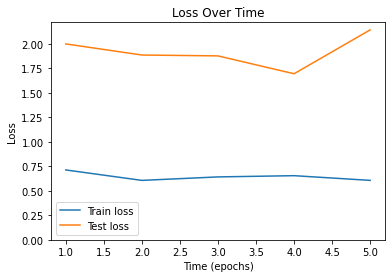

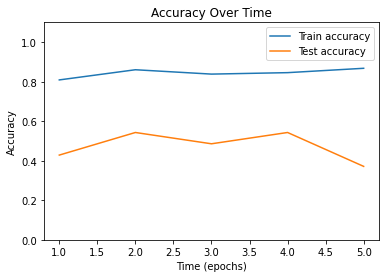

In [ ]:
def plot_loss(train_losses=None, test_losses=None):
    if train_losses:
        plt.plot(range(1, len(train_losses)+1), np.array(train_losses).mean(axis=1), label='Train loss')
    if test_losses:
        plt.plot(range(1, len(test_losses)+1), np.array(test_losses).mean(axis=1), label='Test loss')
    plt.xlabel('Time (epochs)')
    plt.ylabel('Loss')
    plt.ylim(0)
    plt.title('Loss Over Time')
    plt.legend()
    plt.show()

def plot_accuracy(train_accuracies=None, test_accuracies=None):
    if train_accuracies:
        plt.plot(range(1, len(train_accuracies)+1), np.array(train_accuracies).mean(axis=1), label='Train accuracy')
    if test_accuracies:
        plt.plot(range(1, len(test_accuracies)+1), np.array(test_accuracies).mean(axis=1), label='Test accuracy')
    plt.xlabel('Time (epochs)')
    plt.ylabel('Accuracy')
    plt.ylim((0, 1.1))
    plt.title('Accuracy Over Time')
    plt.legend()
    plt.show()

plot_loss(train_losses, test_losses)
plot_accuracy(train_accuracies, test_accuracies)

## Testing a single file

In [ ]:
saved_model = load_checkpoint('mod-checkpoint-35_epochs.pth').cuda()

hazel-unknown.m4a


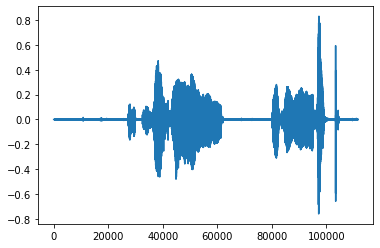

In [ ]:
def plot_waveform(waveform):
    plt.plot(waveform.t().numpy())
    plt.show()

def convert_file_to_wav(path):
    new_path = '.'.join(path.split('.')[:-1]) + '.wav'
    !ffmpeg -y -i {path} {new_path} -hide_banner > /dev/null 2>&1
    return new_path

def resample(waveform, original_rate, new_rate):
    resampler = torchaudio.transforms.Resample(original_rate, new_rate)
    return resampler(waveform), new_rate

def open_audio_file(path, target_rate=8000):
    if path[-4:] != '.wav':
        path = convert_file_to_wav(path)
    waveform, sample_rate = torchaudio.load(path)
    if sample_rate != target_rate:
        return resample(waveform, sample_rate, target_rate)
    return waveform, sample_rate

def test_a_waveform(waveform, model):
    waveform = waveform.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
    output_dist, _ = model(waveform.unsqueeze(0))
    output = output_dist.mean(axis=0).argmax().item()
    output_label = clean_train_data.target_decoding[output]
    return output_label, output_dist.mean(axis=0).squeeze().cpu().detach().numpy()

filepath = 'hazel-unknown.m4a'
print(filepath)
waveform, sample_rate = open_audio_file(filepath)
plot_waveform(waveform)
display(Audio(waveform, rate=sample_rate))
prediction = test_a_waveform(waveform, saved_model)

In [ ]:
print('The model predicted:', prediction)

The model predicted: ('tired', array([-0.6438616 ,  1.3686838 , -1.2921115 , -1.42563   , -0.20611389],
      dtype=float32))


# Other Evaluations

In [ ]:
epoch_checkpoint = 5

saved_model = load_checkpoint(f'checkpoint-{epoch_checkpoint}_epochs.pth').cuda()
print(f'Trained for {saved_model.num_epochs_trained} epochs')

clean_test_loader = DataLoader(clean_test_data, batch_size=1, shuffle=False, num_workers=2, pin_memory=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loss = torch.nn.CrossEntropyLoss()
bar = tqdm(total=len(clean_test_loader), position=0, leave=True, desc='evaluating test set')

losses, accuracies, preds = evaluate(saved_model, clean_test_loader, loss, device, bar)
print('accuracy:', np.array(accuracies).mean())
print('f1 micro:', f1_score(clean_test_data.data.target, preds, average='micro'))
print('f1 macro:', f1_score(clean_test_data.data.target, preds, average='macro'))

evaluating:   0%|          | 0/35 [00:00<?, ?it/s]         

Trained for 5 epochs


evaluating: 100%|██████████| 35/35 [00:25<00:00,  1.34it/s]

accuracy: 0.5714285714285714
f1 micro: 0.5714285714285714
f1 macro: 0.14545454545454545


evaluating: 100%|██████████| 875/875 [10:05<00:00,  1.57it/s]

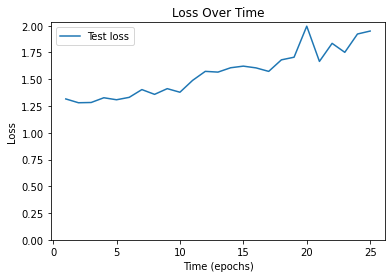

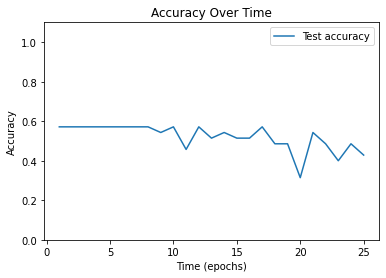

In [ ]:
def collect_stats(i):
    clean_test_loader = DataLoader(clean_test_data, batch_size=1, shuffle=False, num_workers=2, pin_memory=True)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    loss = torch.nn.CrossEntropyLoss()
    bar = tqdm(total=len(clean_test_loader)*i, position=0, leave=True, desc='evaluating test set')
    
    losses, accuracies = [], []
    for epoch_checkpoint in range(1, i+1):
        saved_model = load_checkpoint(f'mod-checkpoint-{epoch_checkpoint}_epochs.pth').cuda()

        loss_, accuracy_, _ = evaluate(saved_model, clean_test_loader, loss, device, bar)
        losses.append(loss_)
        accuracies.append(accuracy_)
    return losses, accuracies

losses, accuracies = collect_stats(25)
plot_loss(test_losses=losses)
plot_accuracy(test_accuracies=accuracies)

## some irrelevant stuff

### prep original corpus files

In [ ]:
%%capture
%%bash

cd donateacry-corpus/donateacry-ios-upload-bucket/
if [ ! -d converted-wav ]; then
    mkdir converted-wav
    for i in *.caf;
        do name=`echo "$i" | cut -d '.' -f1-2`
        echo "$name"
        ffmpeg -i "$i" "converted-wav/${name}.wav" -hide_banner
    done
fi

In [ ]:
%%capture
%%bash

cd donateacry-corpus/donateacry-android-upload-bucket/
if [ ! -d converted-wav ]; then
    mkdir converted-wav
    for i in *.3gp;
        do name=`echo "$i" | cut -d '.' -f1-2`
        echo "$name"
        ffmpeg -i "$i" "converted-wav/${name}.wav" -hide_banner
    done
fi

In [ ]:
original_dirs = [
    './donateacry-corpus/donateacry-ios-upload-bucket/converted-wav/',
    './donateacry-corpus/donateacry-android-upload-bucket/converted-wav/',
]

train_data = DonateACryDataset(original_dirs, train=True)
train_loader = DataLoader(train_data, batch_size=1, shuffle=True, num_workers=2, pin_memory=True)

test_data = DonateACryDataset(original_dirs, train=False)
test_loader = DataLoader(test_data, batch_size=1, shuffle=False, num_workers=2, pin_memory=True)

skipping CF7F6316-019B-4B3C-9EE1-A62EB5F1D0EE-1426957748.47029-1-0911C8F7-99D0-4A44-BC34-894BA5D83032-f-26-ti.wav
skipping CF7F6316-019B-4B3C-9EE1-A62EB5F1D0EE-1426958010-1.0-96274EC9-59EB-49E3-96F3-A24D498FB7C3-f-26-ti.wav
skipping CF7F6316-019B-4B3C-9EE1-A62EB5F1D0EE-1426957748.47029-1-0911C8F7-99D0-4A44-BC34-894BA5D83032-f-26-ti.wav
skipping CF7F6316-019B-4B3C-9EE1-A62EB5F1D0EE-1426958010-1.0-96274EC9-59EB-49E3-96F3-A24D498FB7C3-f-26-ti.wav


### a new attempt at RNN structure
with no embeddings

In [ ]:
class NewRNN(nn.Module):
    def __init__(self, hidden_size, output_size, n_layers, bidirectional=True):
        super(NewRNN, self).__init__()
        self.__dict__.update(locals())

        # self.linear_in = nn.Linear(self.)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size, self.n_layers, bidirectional=self.bidirectional)
        bidirectional_multiplier = 2 if self.bidirectional else 1
        self.linear_out = nn.Linear(self.hidden_size * bidirectional_multiplier, self.output_size)
    
    def forward(self, waveform, hidden):
        output, hidden = self.gru(waveform, hidden)
        output = self.linear_out(output)
        return output, hidden

def train(train_loader, num_epochs, model, optimizer, criterion, device):
    bar = tqdm(total=num_epochs*len(train_loader), position=0, leave=True)
    for epoch in range(num_epochs):
        hidden = None
        for i, (waveform, target) in enumerate(train_loader):
            optimizer.zero_grad()
            waveform = waveform.to(device)
            
            pdb.set_trace()
            output, hidden = model(waveform, hidden)
            
            loss = criterion(output.squeeze(1), target)
            bar.set_description(f'loss: {loss.item()}')
            bar.update()
            loss.backward(retain_graph=True)
            optimizer.step()

    return loss.item()

def scope():
    device = torch.device("cuda")
    model = NewRNN(hidden_size=80, output_size=5, n_layers=2, bidirectional=False).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    loss = torch.nn.CrossEntropyLoss()
    train(clean_train_loader, 5, model, optimizer, loss, device)

scope()

  0%|          | 0/1825 [00:00<?, ?it/s]

> <ipython-input-13-115cfa9c756d>(25)train()
-> output, hidden = model(waveform, hidden)
(Pdb) waveform.shape
torch.Size([1, 1, 56000])
(Pdb) exit


BdbQuit: ignored


### old RNN implementation
training on individual windows

In [ ]:
## train windows separately
def train(train_loader, num_epochs, model, optimizer, criterion, device):
    bar = tqdm(total=num_epochs*len(train_loader), position=0, leave=True)
    for epoch in range(num_epochs):
        hidden = None
        for i, (waveform, target) in enumerate(train_loader):
            optimizer.zero_grad()
            waveform = waveform.to(device).detach()
            target = target.to(device)
            loss = 0
            for j, window in enumerate(model.window_generator(waveform)):
                print(i, j)
                # window.requires_grad_(True)
                output, hidden = model.forward(window, hidden)            
                loss = loss + criterion(output.squeeze(1), target)
            bar.update()
            bar.set_description(f'loss: {loss.item()}')
            loss.backward()
            optimizer.step()

    return loss.item()